<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CatsDogsKerasInterpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs Keras Interpretation
* We'll use a a Convnet & VGG to peer inside what our deep net is learning
* Our Convnet is far from state of art, but augments and trains quickly
* VGG will be used to look at weights on Conv filters
* Deep Learning with Python (Chollet)

# Setup

In [0]:
from zipfile import ZipFile
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [36]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers

1.15.0


# Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/Data/CatsDogs/data.zip"
file   = "/content/drive/My Drive/Data/CatsDogs/data.zip"

'/content/drive/My Drive/Data/CatsDogs/data.zip'


In [0]:
!mkdir -p /tmp/catdog
with ZipFile(file, 'r') as zip: 
  zip.extractall('/tmp/catdog/')

In [0]:
base_dir       = '/tmp/catdog/'
test_dir       = '/tmp/catdog/test/'
training_dir   = '/tmp/catdog/training/'
validation_dir = '/tmp/catdog/validation/'

!mkdir -p "$base_dir"

!rm -fr "$test_dir"
!mkdir -p "$test_dir"
!mkdir -p "$test_dir/cats"
!mkdir -p "$test_dir/dogs"

!rm -fr "$training_dir"
!mkdir -p "$training_dir"
!mkdir -p "$training_dir/cats"
!mkdir -p "$training_dir/dogs"

!rm -fr "$validation_dir"
!mkdir -p "$validation_dir"
!mkdir -p "$validation_dir/cats"
!mkdir -p "$validation_dir/dogs"

# Images

In [0]:
range_train = 1000
range_validation = 1500
range_test = 2000

In [0]:
def copyFiles(prefix, dest, start, end):
  if prefix != 'cat' and prefix != 'dog':
    raise ValueError('Must pass cat or dog for prefix')
  srcFolder  = os.path.join(base_dir, 'train')
  destFolder = os.path.join(base_dir, dest, prefix + 's')
  print(srcFolder, '->', destFolder, start, end)
  for file in  ['{}.{}.jpg'.format(prefix, index) for index in range(start, end)]:
    shutil.copy(os.path.join(srcFolder, file), os.path.join(destFolder, file))

In [9]:
copyFiles('cat', 'training', 0, range_train)
copyFiles('cat', 'validation', range_train, range_validation)
copyFiles('cat', 'test', range_validation, range_test)

copyFiles('dog', 'training', 0, range_train)
copyFiles('dog', 'validation', range_train, range_validation)
copyFiles('dog', 'test', range_validation, range_test)

/tmp/catdog/train -> /tmp/catdog/training/cats 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/cats 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/cats 1500 2000
/tmp/catdog/train -> /tmp/catdog/training/dogs 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/dogs 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/dogs 1500 2000


# Model


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)  

# Train

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen       = ImageDataGenerator(rescale=1. / 255)

print(training_dir)
train_gen = train_datagen.flow_from_directory(
  training_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(validation_dir)
validation_gen = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(test_dir)
test_gen = test_datagen.flow_from_directory(
  test_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary', 
  shuffle=False) # Don't shuffle predictions

/tmp/catdog/training/
Found 2000 images belonging to 2 classes.
/tmp/catdog/validation/
Found 1000 images belonging to 2 classes.
/tmp/catdog/test/
Found 1000 images belonging to 2 classes.


# Fit 

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_gen,
    validation_steps=50
)




Epoch 1/30





100/100 [==============================] - 22s 217ms/step - loss: 0.6920 - acc: 0.5075 - val_loss: 0.6879 - val_acc: 0.5140
Epoch 2/30
100/100 [==============================] - 18s 180ms/step - loss: 0.6885 - acc: 0.5315 - val_loss: 0.6825 - val_acc: 0.5730
Epoch 3/30
100/100 [==============================] - 18s 179ms/step - loss: 0.6828 - acc: 0.5615 - val_loss: 0.6812 - val_acc: 0.5260
Epoch 4/30
100/100 [==============================] - 18s 183ms/step - loss: 0.6790 - acc: 0.5635 - val_loss: 0.6753 - val_acc: 0.5730
Epoch 5/30
100/100 [==============================] - 18s 184ms/step - loss: 0.6747 - acc: 0.5765 - val_loss: 0.6687 - val_acc: 0.5780
Epoch 6/30
100/100 [==============================] - 19s 185ms/step - loss: 0.6724 - acc: 0.5835 - val_loss: 0.6612 - val_acc: 0.6020
Epoch 7/30
100/100 [==============================] - 19s 186ms/step - loss: 0.6670 - acc: 0.5925 - val_loss: 0.6585 - val_acc: 0.6040
Epoch 8/30
100/100 [===========================

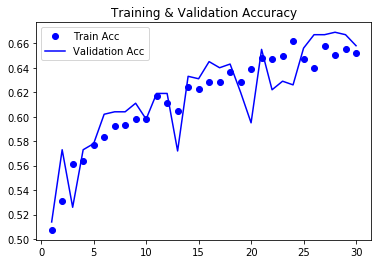

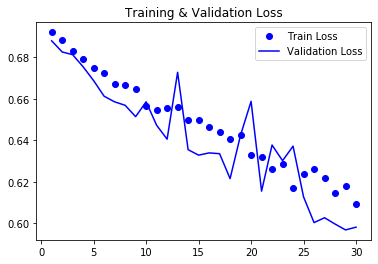

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Test Accuracy
* Around 90% -- Not aiming at state of the art here

In [15]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('Test Accuracy {:.4f}'.format(test_acc))

Test Accuracy 0.6530


# Visualizing Activations in Layers

## Load One Image

In [0]:
img = image.load_img(test_dir + '/cats/cat.1700.jpg', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

## Plot Image

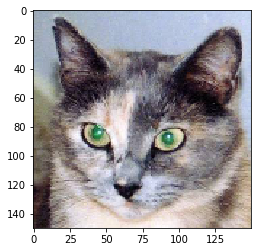

In [23]:
plt.imshow(img_tensor[0])
plt.show()

## Layer Output

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [0]:
layer_outputs = [l.output for l in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]

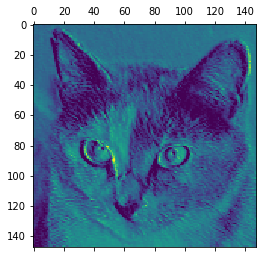

In [26]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

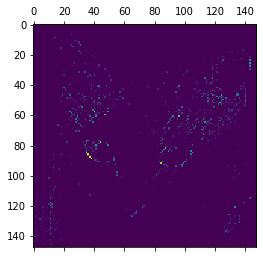

In [28]:
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

In [0]:
#ZipFile clobbered zip
def myZip(*iterables):
    # zip('ABCD', 'xy') --> Ax By
    sentinel = object()
    iterators = [iter(it) for it in iterables]
    while iterators:
        result = []
        for it in iterators:
            elem = next(it, sentinel)
            if elem is sentinel:
                return
            result.append(elem)
        yield tuple(result)

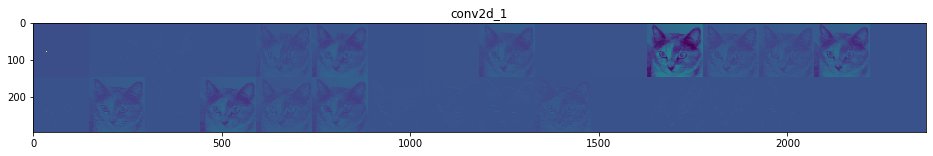

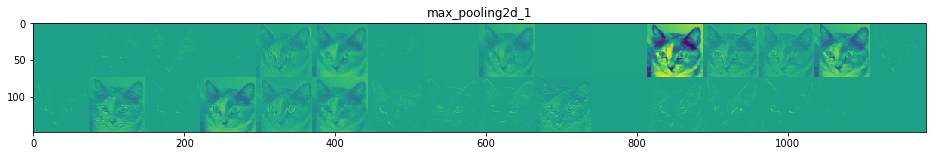

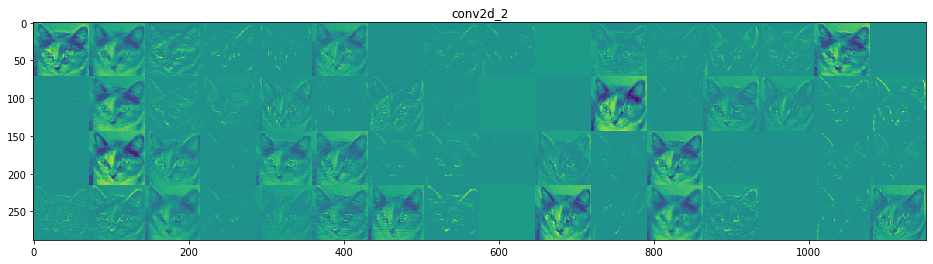

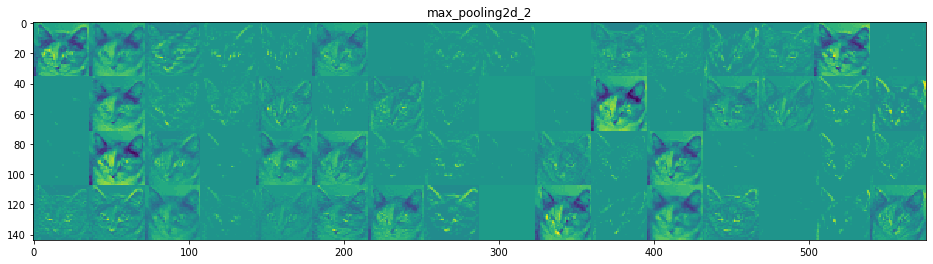

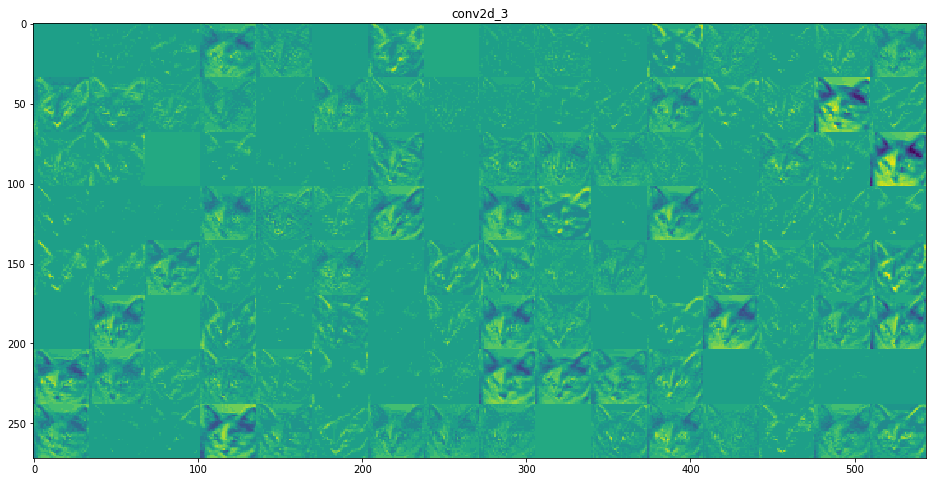

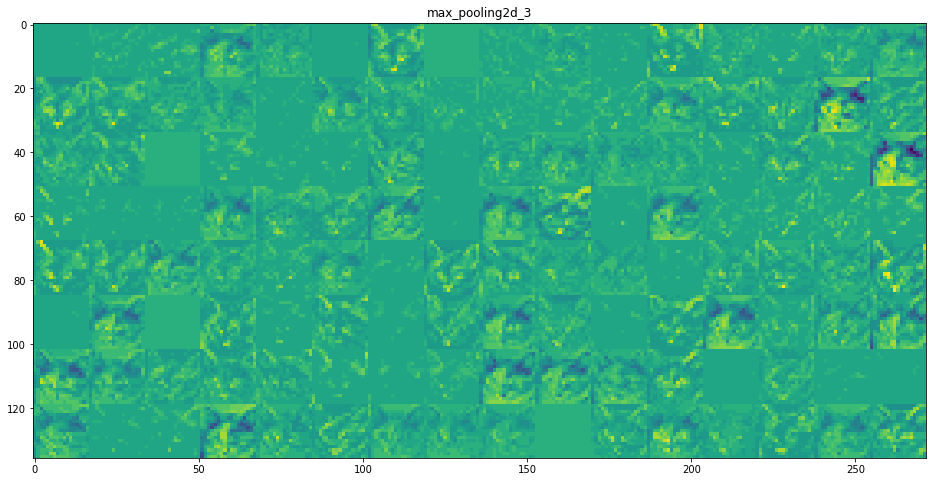

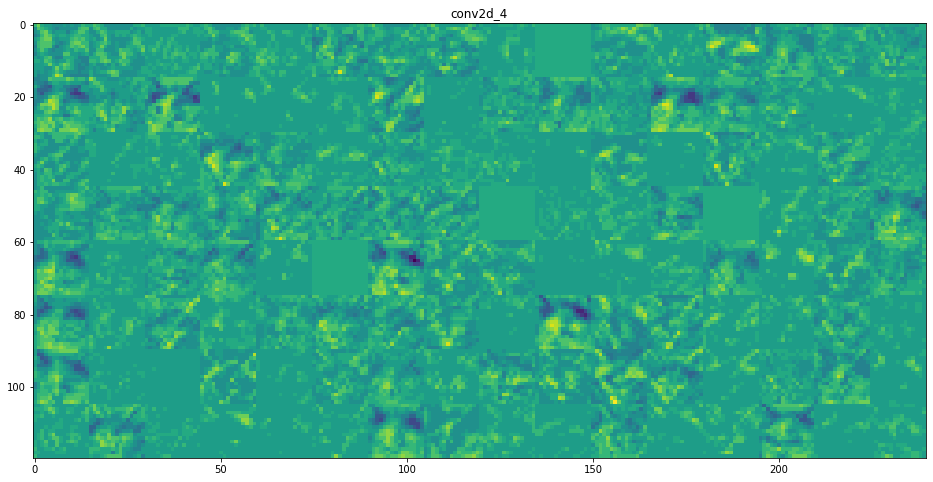

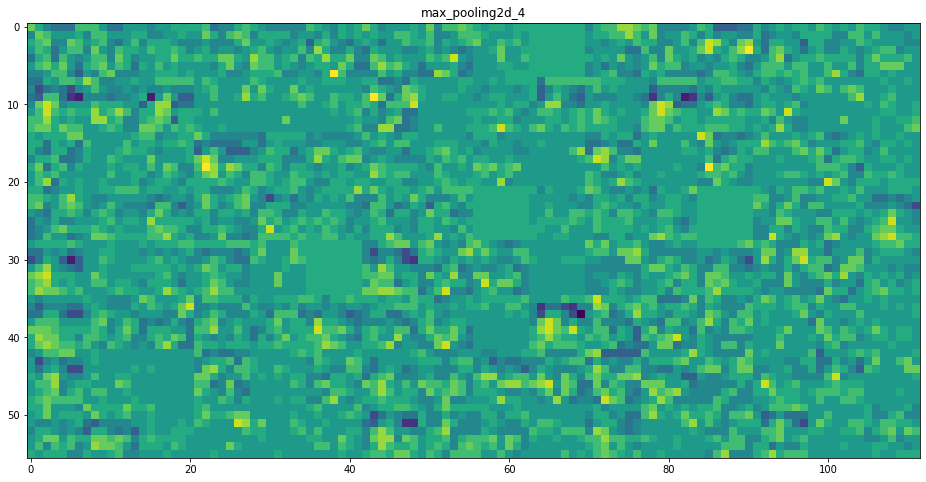

In [35]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

per_row = 16

for layer_name, layer_activation in myZip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // per_row
  display_grid = np.zeros((size * n_cols, per_row * size))
  for col in range(n_cols):
    for row in range(per_row):
      channel_img = layer_activation[0, :, :, col * per_row + row]
      channel_img -= channel_img.mean()
      channel_img *= 64
      channel_img += 128
      channel_img = np.clip(channel_img, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_img
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

# VGG - Filters

In [0]:
vggModel = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

## Get Loss

In [0]:
layer_output = vggModel.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

## Gradients

In [0]:
grads = K.gradients(loss, vggModel.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([vggModel.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

## Loss Maximization

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128
step 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

## Tensor to Image

In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')

  return x

## Generate Filters

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = vggModel.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, vggModel.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([vggModel.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

  step = 1
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

  img = input_img_data[0]
  return deprocess_image(img)

# Show

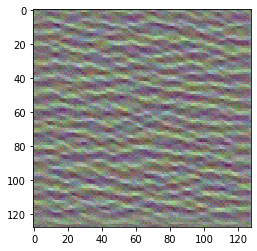

In [66]:
plt.imshow(generate_pattern('block3_conv1', 1, 128))

# Grid

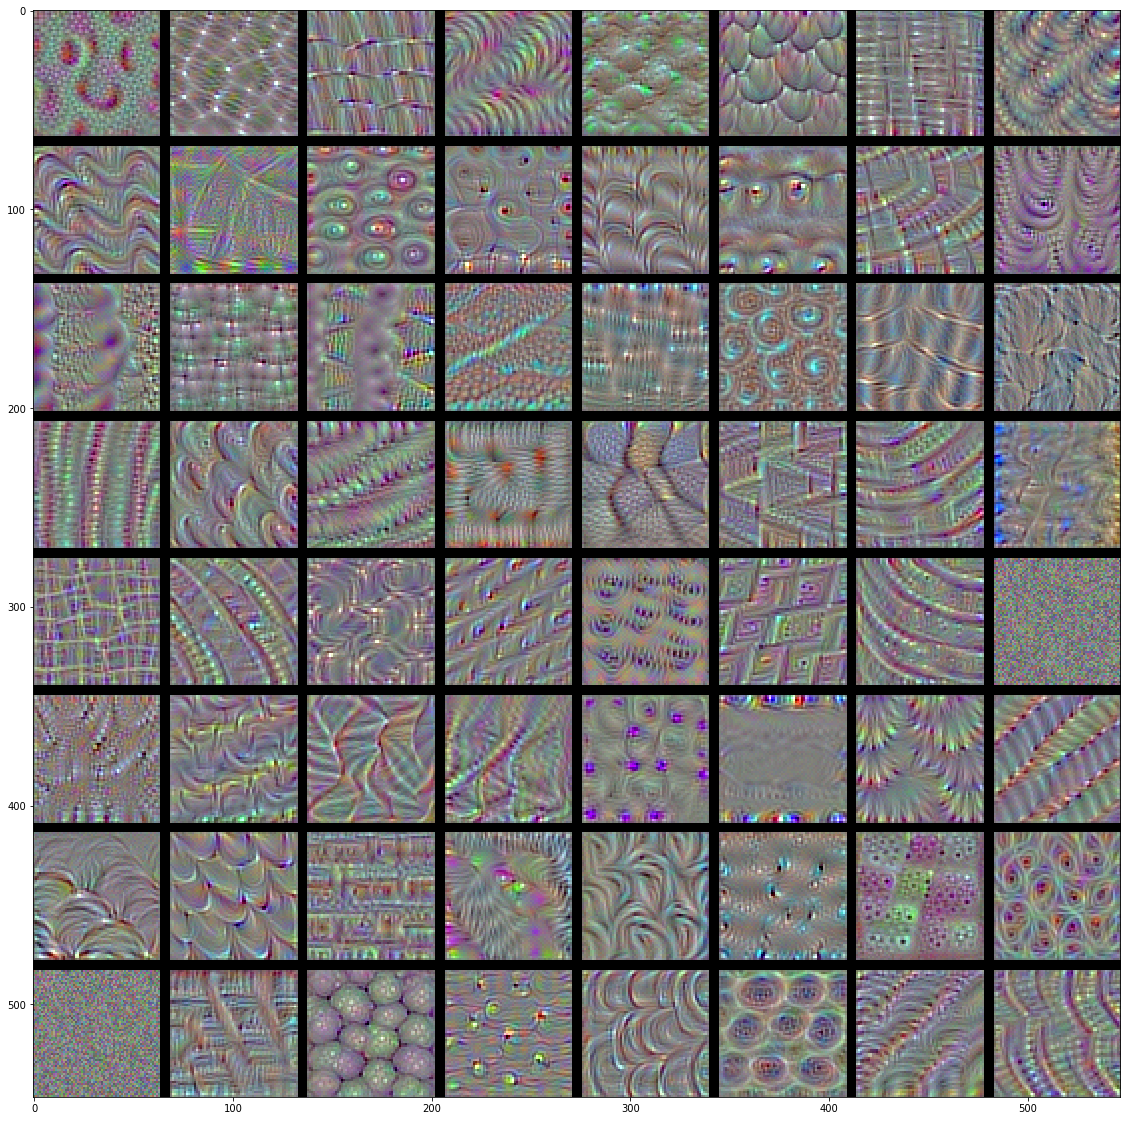

In [74]:
layer_name = 'block4_conv1'
size = 64
margin = 5
values = 8

results = np.zeros((values * size + 7 * margin, 
                    values * size + 7 * margin,
                    3))

for i in range(values):
  for j in range(values):
    filter_img = generate_pattern(layer_name, i + (j * values), size=size)

    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

results /= 255.
plt.figure(figsize=(20,20))
plt.imshow(results)